# Project: What can we say about a typical parking violation in New York?

## Table of Contents:
* [Introduction](#1)
* [Wrangling](#2)
* [Exploratory Visuals](#3)
* [Explanatory Visuals](#4)
* [Conclusion](#5)

## Introduction:<a class="anchor" id="1"></a>
to be added

In [2]:
# import all packages and set plots to be embedded inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
from patsy import dmatrices
import statsmodels.api as sm;
from datetime import *
from statsmodels.stats.outliers_influence import variance_inflation_factor

%matplotlib inline

In [16]:
# Large dataset, we want to see all columns
pd.set_option('display.max_columns', None)

In [17]:
# read in .csv
df_og = pd.read_csv('parking-violations-issued-fiscal-year-2018.csv', low_memory = False)

## Wrangling:

In [18]:
df_og.head()

,Summons Number,Plate ID,Registration State,Plate Type,Issue Date,Violation Code,Vehicle Body Type,Vehicle Make,Issuing Agency,Street Code1,Street Code2,Street Code3,Vehicle Expiration Date,Violation Location,Violation Precinct,Issuer Precinct,Issuer Code,Issuer Command,Issuer Squad,Violation Time,Time First Observed,Violation County,Violation In Front Of Or Opposite,House Number,Street Name,Intersecting Street,Date First Observed,Law Section,Sub Division,Violation Legal Code,Days Parking In Effect,From Hours In Effect,To Hours In Effect,Vehicle Color,Unregistered Vehicle?,Vehicle Year,Meter Number,Feet From Curb,Violation Post Code,Violation Description,No Standing or Stopping Violation,Hydrant Violation,Double Parking Violation
0,1105232165,GLS6001,NY,PAS,2018-07-03T00:00:00.000,14,SDN,HONDA,X,47130,13230,80030,20180702.0,78.0,78,968,86684,0968,0000,0811P,NaN,K,F,2,HANSON PLACE,NaN,0,408,D1,NaN,BBYBBBB,ALL,ALL,BLUE,0.0,2006,-,0,NaN,NaN,NaN,NaN,NaN
1,1121274900,HXM7361,NY,PAS,2018-06-28T00:00:00.000,46,SDN,NISSA,X,28990,14890,15040,20200203.0,112.0,112,968,103419,0968,0000,1145A,NaN,Q,F,71-30,AUSTIN ST,NaN,0,408,C,NaN,BBBBBBB,ALL,ALL,GRY,0.0,2017,-,0,NaN,NaN,NaN,NaN,NaN
2,1130964875,GTR7949,NY,PAS,2018-06-08T00:00:00.000,24,SUBN,JEEP,X,64,18510,99,20180930.0,122.0,122,835,0,0835,0000,0355P,NaN,R,NaN,NaN,GREAT KILLS BOAT LAU,NaN,0,408,D5,NaN,BBBBBBB,ALL,ALL,GREEN,0.0,0,-,0,NaN,NaN,NaN,NaN,NaN
3,1130964887,HH1842,NC,PAS,2018-06-07T00:00:00.000,24,P-U,FORD,X,11310,39800,39735,0.0,122.0,122,835,0,0835,0000,0123P,NaN,R,NaN,NaN,GREAT KILLS PARK BOA,NaN,0,408,D5,NaN,BBBBBBB,ALL,ALL,WHITE,0.0,0,-,0,NaN,NaN,NaN,NaN,NaN
4,1131599342,HDG7076,NY,PAS,2018-06-29T00:00:00.000,17,SUBN,HYUND,X,47130,13230,80030,20190124.0,78.0,78,868,2354,0868,0000,0514P,NaN,K,F,2,HANSON PLACE,NaN,0,408,C4,NaN,BBBBBBB,ALL,ALL,GREEN,0.0,2007,-,0,NaN,NaN,NaN,NaN,NaN


In [19]:
# let's create a copy we will work with
df = df_og.copy()

In [20]:
# Selecting the columns we want to work with
df = df[['Registration State', 'Issue Date', 'Violation Time', 'Violation Code', 'Vehicle Body Type', 'Vehicle Make', 'Vehicle Color', 'Vehicle Year']]

In [21]:
# change column names to lower case and eliminate empty space
df.columns = ['registration_state', 'issue_date', 'violation_time', 'violation_code', 'vehicle_body_type', 'vehicle_make', 'vehicle_color', 'vehicle_year']

In [22]:
# drop duplicate rows and rows with missing value
df.drop_duplicates(inplace = True)
df.dropna(inplace = True)

In [23]:
# Convert Issue Date to datetime object
df.issue_date = pd.to_datetime(df.issue_date)

In [24]:
# Get rid of incorrect violation time data
mask = (df.violation_time.str.len() == 5) & (df.violation_time.str.count('\.') == 0) & (df.violation_time.str.count(' ') == 0)

df = df.loc[mask]

In [25]:
# Add flag column for additional filtering later on
df['flag'] = False
df = df.reset_index(drop=True)

In [26]:
for i in df.index:
    # grab violation time at row i
    v_time = df.get_value(i, 'violation_time')
    
    # tokenize hour, minute, and PM/AM characters into different variables, cast to int as necessary
    h = int(v_time[0:2])
    m = int(v_time[2:4])
    p = v_time[4:5]
    
    # flag rows with erroneous violation time values (ex. 6831P) 
    if h >= 24:
        df.set_value(i, 'flag', True)   
    if m >= 60:
        df.set_value(i, 'flag', True)
    
    # if violation time is PM, add 12 to hour value
    if p == 'P':
        h += 12
    
    # add time data to issue date data using timedelta
    df.set_value(i, 'issue_date', df.issue_date[i] + timedelta(hours = h, minutes = m))

A:\Anaconda3\lib\site-packages\ipykernel\__main__.py:3: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  app.launch_new_instance()
A:\Anaconda3\lib\site-packages\ipykernel\__main__.py:21: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
A:\Anaconda3\lib\site-packages\ipykernel\__main__.py:12: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead


In [27]:
# remove flagged rows
df = df.query('flag == False')

In [28]:
# drop violation time as it's no longer needed
df.drop('violation_time', axis = 1, inplace = True)

In [29]:
df.head()

,registration_state,issue_date,violation_code,vehicle_body_type,vehicle_make,vehicle_color,vehicle_year,flag
0,NY,2018-07-03 20:11:00,14,SDN,HONDA,BLUE,2006,False
1,NY,2018-06-28 11:45:00,46,SDN,NISSA,GRY,2017,False
2,NY,2018-06-08 15:55:00,24,SUBN,JEEP,GREEN,0,False
3,NC,2018-06-07 13:23:00,24,P-U,FORD,WHITE,0,False
4,NY,2018-06-29 17:14:00,17,SUBN,HYUND,GREEN,2007,False


In [30]:
# create a dictionary for all registration states of North America (US, Canada, Mexico)
states = {'AL', 'AK', 'AZ', 'AR', 'AA', 'AE', 'AP', 'CA', 'CO', 'CT', 'DE', 'DC', 'FL', 'GA', 'HI', 'ID', 'IL', 'IN', 'IA',
         'KS', 'KY', 'LA', 'ME', 'MD', 'MA', 'MI', 'MN', 'MS', 'MO', 'MT', 'NE', 'NV', 'NH', 'NJ', 'NM', 'NY', 'NC', 'ND',
         'OH', 'OK', 'OR', 'PA', 'RI', 'SC', 'SD', 'TN', 'TX', 'UT', 'VT', 'VA', 'WA', 'WV', 'WI', 'WY', 'AB', 'BC', 'MB',
         'NB', 'NF', 'NT', 'NS', 'NU', 'ON', 'PE', 'QC', 'SK', 'YT', 'AG', 'BJ', 'BS', 'CP', 'CH', 'CI', 'CU', 'CL', 'DF',
         'DG', 'GJ', 'GR', 'HG', 'JA', 'EM', 'MH', 'MR', 'NA', 'NL', 'OA', 'PU', 'QA', 'QR', 'SL', 'SI', 'SO', 'TA', 'TM',
         'TL', 'VZ', 'YC', 'ZT'}

In [31]:
# if registration state code is not found in states dictionary, flag it as True
df.flag = ~df.registration_state.isin(states)

In [32]:
# cast violation code as string object, we will not be performing numeric calculation with these nominal values
df.violation_code = df.violation_code.astype('str')

In [33]:
# remove all parking violations that had less than mean amount (142) of all parking violation locations
#s = df.street_name.value_counts()
#df = df[df.isin(s.index[s >= 142]).values]

There is a huge amount of mess here with **vehicle body types**. Same type of vehicles are represented with different abbreviations, and some don't even appear under official NY vehicle registration sheet (https://data.ny.gov/api/assets/83055271-29A6-4ED4-9374-E159F30DB5AE). I will be combining the same vehicle types under official abbreviations. For the purposes of this analysis we will only be concerned with commercially distinguishable vehicle body types.

In [34]:
# create dictionaries of vehicle body types we want to use
body = {'SUBN', '4DSD', 'VAN', 'PICK', '2DSD', 'REFG', 'TRAC', 'UTIL', 'TAXI', 'CONV', 'BUS', 
        'TRLR', 'MCY', 'TRK', 'DUMP', 'TR/C'}

In [35]:
# iterating through dataframe and grab its body type
for i in df.index:
    body_type = df.get_value(i, 'vehicle_body_type')
    
    # Fixing 4 door sedan
    if (body_type == '4 DR') | (body_type == '4D'):
        df.set_value(i, 'vehicle_body_type', '4DSD')
    
    # Fixing PickUp Trucks
    elif (body_type == 'P-U') | (body_type == 'PKUP'):
        df.set_value(i, 'vehicle_body_type', 'PICK')
    
    # Fixing Utility Vehicles
    elif body_type == 'UT':
        df.set_value(i, 'vehicle_body_type', 'UTIL')
        
    # Combining Trailer and Semi-Trailer
    elif body_type == 'SEMI':
        df.set_value(i, 'vehicle_body_type', 'TRLR')
    
    # Combining Flat base trucks, Trucks, and Tow trucks
    elif (body_type == 'FLAT') | (body_type == 'TOW'):
        df.set_value(i, 'vehicle_body_type', 'TRK')

A:\Anaconda3\lib\site-packages\ipykernel\__main__.py:3: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  app.launch_new_instance()
A:\Anaconda3\lib\site-packages\ipykernel\__main__.py:11: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
A:\Anaconda3\lib\site-packages\ipykernel\__main__.py:7: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
A:\Anaconda3\lib\site-packages\ipykernel\__main__.py:15: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
A:\Anaconda3\lib\site-packages\ipykernel\__main__.py:23: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
A:\Anaconda3\lib\site-packages\ipykernel\__main__.py:19: FutureW

In [36]:
# Flag all rows with body types we are not concerned with
df.flag = ~df.vehicle_body_type.isin(body)

In [37]:
# remove flagged rows
df = df.query('flag == False')

There is also a huge amount of mess with **vehicle make**. Same type of vehicles are represented with different abbv, and may do not appear under NY's official vehicle make database (https://data.ny.gov/Transportation/Vehicle-Makes-and-Body-Types-Most-Popular-in-New-Y/3pxy-wy2i). For the purposes of the analysis, commercially distinguishable vehicle makes will be combined under 1 abbreviation.

In [38]:
# create a dictionary of all car manufacturers we want to use
make = {'FORD', 'TOYOT', 'HONDA', 'NISSA', 'CHEVR', 'MERZ', 'DODGE', 'FRUEH', 'JEEP', 'BMW', 'HYUND',
       'LEXUS', 'GMC', 'ACURA', 'INFIN', 'SUBAR', 'VOLKS', 'CHRYS', 'AUDI', 'KIA', 'MAZDA', 'HIN', 'ISUZU',
       'ROVER', 'CADIL', 'VOLVO', 'MITSU', 'LINCO', 'BUICK', 'MERCU', 'PORSC', 'MINI', 'SMART', 'SATUR',
       'JAGUA', 'PONTI', 'FIAT', 'SUZUK', 'TESLA', 'MASE', 'SAAB', 'SCION', 'YAMAH', 'KAWAS', 'DUCAT',
       'FERRA', 'ROLLS', 'LAMBO', 'LEXUS', 'KENWO'}

In [39]:
# iterating through dataframe and grab its make
for i in df.index:
    make_manu = df.get_value(i, 'vehicle_make')
    
    # Fixing Mercedes Benz
    if (make_manu == 'ME/BE') | (make_manu == 'M-B'):
        df.set_value(i, 'vehicle_make', 'MERZ')
    
    # Fixing Hyundai
    elif (make_manu == 'HYUN') | (make_manu == 'HYUNN') | (make_manu == 'HYUAN'):
        df.set_value(i, 'vehicle_make', 'HYUND')
    
    # Fixing GMC
    elif (make_manu == 'DAEWO') | (make_manu == ' GMC'):
        df.set_value(i, 'vehicle_make', 'GMC')
    
    # Fixing Volkswagen
    elif (make_manu == 'VOLK') | (make_manu == 'VOKLS'):
        df.set_value(i, 'vehicle_make', 'VOLKS')
        
    # Fixing Kia
    elif (make_manu == 'KIA.') | (make_manu == ' KIA'):
        df.set_value(i, 'vehicle_make', 'KIA')
        
    # Fixing Lexus
    elif (make_manu == 'LEX') | (make_manu == 'LEXU') | (make_manu == 'LEXSU') | (make_manu == ' LEXU'):
        df.set_value(i, 'vehicle_make', 'LEXUS')
        
    # Fixing Mitsubishi
    elif (make_manu == 'MIYSU') | (make_manu == 'HITSU') | (make_manu == 'MITBI'):
        df.set_value(i, 'vehicle_make', 'MITSU')
        
    # Fixing Ford
    elif (make_manu == 'FORDB') | (make_manu == 'FORDF'):
        df.set_value(i, 'vehicle_make', 'FORD')
        
    # Fixing Subaru
    elif make_manu == 'SUBA':
        df.set_value(i, 'vehicle_make', 'SUBAR')
        
    # Fixing Saturn
    elif (make_manu == 'SATUN') | (make_manu == 'SETUR'):
        df.set_value(i, 'vehicle_make', 'SATUR')
        
    # Fixing Chrysler
    elif (make_manu == 'CHHRY') | (make_manu == 'CHCRY'):
        df.set_value(i, 'vehicle_make', 'CHRYS')   
        
    # Fixing Mazda
    elif make_manu == 'MADA':
        df.set_value(i, 'vehicle_make', 'MAZDA')
        
    # Fixing Acura
    elif (make_manu == 'ACYRA') | (make_manu == 'ACUR') | (make_manu == 'ACUCA'):
        df.set_value(i, 'vehicle_make', 'ACURA')
        
    # Fixing Cadillac
    elif (make_manu == 'CADDL'):
        df.set_value(i, 'vehicle_make', 'CADIL')
        
    # Fixing Porsche
    elif (make_manu == 'PORS') | (make_manu == 'PORSD'):
        df.set_value(i, 'vehicle_make', 'PORSC')    
    
    # Fixing Toyota
    elif make_manu == 'TOTOY':
        df.set_value(i, 'vehicle_make', 'TOYOT')
        
    # Fixing Kenworth
    elif (make_manu == 'KW') | (make_manu == 'KEN') | (make_manu == 'KENW'):
        df.set_value(i, 'vehicle_make', 'KENWO')

A:\Anaconda3\lib\site-packages\ipykernel\__main__.py:3: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  app.launch_new_instance()
A:\Anaconda3\lib\site-packages\ipykernel\__main__.py:7: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
A:\Anaconda3\lib\site-packages\ipykernel\__main__.py:11: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
A:\Anaconda3\lib\site-packages\ipykernel\__main__.py:27: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
A:\Anaconda3\lib\site-packages\ipykernel\__main__.py:39: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
A:\Anaconda3\lib\site-packages\ipykernel\__main__.py:19: FutureW

In [40]:
# Flag all rows with manufacturers we are not concerned with
df.flag = ~df.vehicle_make.isin(make)

In [41]:
# remove flagged rows
df = df.query('flag == False')

Some mess here in the **vehicle year** data. Around 1.3 car's manufacture year could not be identified. This dataset collects all parking enforcement in NY in 2018 and 2019 car models do go on sale in 2018. Therefore, we will be getting rid of all rows with manufacture date recorded as 2020 and up.

using `value_counts(sort = False)` returns all registered vehicle years in ascending order. We see that 0 is the lowest value followed by 1970. We will be concerned with records of vehicles year made between 1970 and 2019.

In [42]:
df = df[(df.vehicle_year >= 1970) & (df.vehicle_year <= 2019)]

There is a lot of mess with **vehicle color** as well and most if not all mess is caused by typos. We will be replacing the colors with proper color names.

In [43]:
color_dic = {'GRAY', 'WHITE', 'BLACK', 'RED', 'YELLOW', 'SILVER', 'BLUE', 'GOLD', 'ORANGE', 'BROWN', 'BEIGE', 'GREEN', 'PURPLE', 'PINK'}

In [44]:
for i in df.index:
    color = df.get_value(i, 'vehicle_color')
    
    # Fixing GRAY
    if color in ('DKGY', 'GYGY', 'GR', 'GY', 'GRY', 'GREY', 'GRAY', 'GY/', 'GY.', 'GRY.', 'GREY.', 'GRAY.', 'ASH'):
        df.set_value(i, 'vehicle_color', 'GRAY')
    
    # Fixing WHITE
    elif color in ('W', 'WH', 'WT', 'WHI', 'WH/', 'WHIT', 'WTE', 'WH.', 'WHTE', 'WHT.', 'CREAM', 'WHTIE', 'DKWH', 
                   'WHIE', 'WHI-T', 'White'):
        df.set_value(i, 'vehicle_color', 'WHITE')
    
    # Fixing BLACK
    elif color in ('BLK', 'BK', 'BK/', 'BLK.', 'DKBK', 'BLAVK', 'BLAK', 'Black', 'BCK', 'BLACJ'):
        df.set_value(i, 'vehicle_color', 'BLACK')
    
    # Fixing RED
    elif color in ('RD', 'DKRD', 'RD/', 'RD.', 'RED.', 'R', 'WINE', 'BED', 'DK RD'):
        df.set_value(i, 'vehicle_color', 'RED')
        
    # Fixing YELLOW
    elif color in ('YW', 'YELLO', 'YEL', 'YELLW', 'YELL', 'YL', 'Y', 'YLW', 'YE', 'YELOW', 'YLLW', 'YWL', 'YW.'):
        df.set_value(i, 'vehicle_color', 'YELLOW')
        
    # Fixing SILVER
    elif color in ('SILVE', 'SIL', 'SILV', 'SLVR', 'SLV', 'SI', 'SLR', 'SLVE', 'SIL.', 'SLVER', 'SIVR', 'SLV.',
                   'SILV.', 'SLIVE', 'SLIVR', 'SLVR.', 'SLIV', 'SIVER', 'SILEV'):
        df.set_value(i, 'vehicle_color', 'SILVER')
    
    # Fixing BLUE
    elif color in ('BLU', 'BL/', 'BLUE.', 'BIU', 'BLU.', 'BRU', 'BLUED', 'BKLUE'):
        df.set_value(i, 'vehicle_color', 'BLUE')
        
    # Fixing GOLD
    elif color in ('GLD', 'GD', 'GOL'):
        df.set_value(i, 'vehicle_color', 'GOLD')
    
    # Fixing ORANGE
    elif color in ('ORANG', 'ORAN', 'OJ', 'COPPE', 'ORNAG', 'OG.', 'ORNG', 'ORANF'):
        df.set_value(i, 'vehicle_color', 'ORANGE')
    
    # Fixing BROWN
    elif color in ('BRN', 'BRW', 'MAROO', 'MAR', 'BRWN', 'MRN', 'MARON', 'BRWON', 'BR.', 'BRONW', 'BRNW'):
        df.set_value(i, 'vehicle_color', 'BROWN')
    
    # Fixing BEIGE
    elif color in ('BEIGE', 'BIEGE', 'BEGE', 'BAIGE', 'BEI'):
        df.set_value(i, 'vehicle_color', 'BEIGE')
    
    # Fixing GREEN
    elif color in ('GRN', 'GN.', 'Green', 'OLIVE', 'LT GN'):
        df.set_value(i, 'vehicle_color', 'GREEN')
        
    # Fixing PURPLE
    elif color in ('PURPL', 'PURP', 'PUR', 'VIOLE', 'PRPL'):
        df.set_value(i, 'vehicle_color', 'PURPLE')
        
    # Fixing PINK
    elif color in ('PK', 'ROSE'):
        df.set_value(i, 'vehicle_color', 'PINK')

A:\Anaconda3\lib\site-packages\ipykernel\__main__.py:2: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  from ipykernel import kernelapp as app
A:\Anaconda3\lib\site-packages\ipykernel\__main__.py:15: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
A:\Anaconda3\lib\site-packages\ipykernel\__main__.py:6: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
A:\Anaconda3\lib\site-packages\ipykernel\__main__.py:28: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
A:\Anaconda3\lib\site-packages\ipykernel\__main__.py:19: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
A:\Anaconda3\lib\site-packages\ipykernel\__main__.p

In [45]:
# Flag all rows with colors we are not concerned with
df.flag = ~df.vehicle_color.isin(color_dic)

In [46]:
# Remove all flagged rows
df = df.query('flag == False')

In [47]:
# adding season and tod (time of day) columns to categorize time
df['season'] = 'NaN'
df['tod'] = 'NaN'

In [48]:
for i in df.index:
    d = df.get_value(i, 'issue_date')
    #print(type(a))
    #d = datetime.strptime(a, '%Y-%m-%d %H:%M:%S')
  
    # Season
    if (d.month < 3) | (d.month == 12):
        df.set_value(i, 'season', 'Winter')
    
    elif (d.month >= 3) & (d.month < 6):
        df.set_value(i, 'season', 'Spring')
    
    elif (d.month >= 6) & (d.month < 9):
        df.set_value(i, 'season', 'Summer')
    
    elif (d.month >= 9) & (d.month < 12):
        df.set_value(i, 'season', 'Fall')
     
    # Time of Day
    if d.hour < 6:
        df.set_value(i, 'tod', 'Overnight')
        
    elif (d.hour >= 6) & (d.hour < 12):
        df.set_value(i, 'tod', 'Morning')
    
    elif (d.hour >= 12) & (d.hour < 18):
        df.set_value(i, 'tod', 'Afternoon')
    
    elif d.hour >= 18:
        df.set_value(i, 'tod', 'Evening')

A:\Anaconda3\lib\site-packages\ipykernel\__main__.py:2: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  from ipykernel import kernelapp as app
A:\Anaconda3\lib\site-packages\ipykernel\__main__.py:14: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
A:\Anaconda3\lib\site-packages\ipykernel\__main__.py:27: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
A:\Anaconda3\lib\site-packages\ipykernel\__main__.py:24: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
A:\Anaconda3\lib\site-packages\ipykernel\__main__.py:30: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
A:\Anaconda3\lib\site-packages\ipykernel\__main__.

In [49]:
df.head()

,registration_state,issue_date,violation_code,vehicle_body_type,vehicle_make,vehicle_color,vehicle_year,flag,season,tod
4,NY,2018-06-29 17:14:00,17,SUBN,HYUND,GREEN,2007,False,Summer,Afternoon
5,NY,2018-07-02 08:27:00,17,SUBN,NISSA,BLACK,2013,False,Summer,Morning
8,NY,2019-07-02 09:19:00,21,SUBN,HONDA,GRAY,2005,False,Summer,Morning
11,NY,2018-07-02 09:02:00,21,SUBN,FORD,BLACK,2012,False,Summer,Morning
12,NY,2018-07-06 08:25:00,17,SUBN,TOYOT,GRAY,2013,False,Summer,Morning


In [50]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3503449 entries, 4 to 5773657
Data columns (total 10 columns):
registration_state    object
issue_date            datetime64[ns]
violation_code        object
vehicle_body_type     object
vehicle_make          object
vehicle_color         object
vehicle_year          int64
flag                  bool
season                object
tod                   object
dtypes: bool(1), datetime64[ns](1), int64(1), object(7)
memory usage: 270.6+ MB


In [51]:
df.to_csv('temp.csv', index = False)

## Visualization

### Registration State

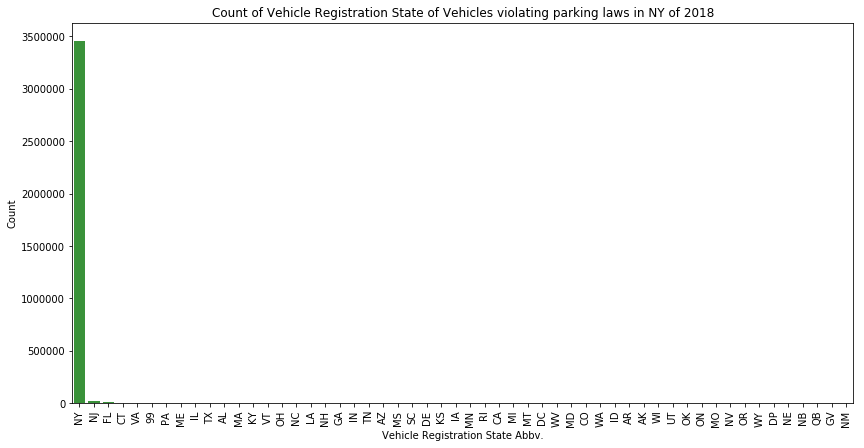

In [52]:
base_color = sb.color_palette()[2]
state_order = df.registration_state.value_counts().index
fig, ax = plt.subplots(figsize=(14, 7))
sb.countplot(data = df, x = 'registration_state', color = base_color, order = state_order)
plt.xlabel('Vehicle Registration State Abbv.')
plt.ylabel('Count')
plt.title('Count of Vehicle Registration State of Vehicles violating parking laws in NY of 2018')
plt.xticks(rotation = 90);

Not very exciting information here. In the state of NY, majority of registered vehicles will be registered in NY.   
This is clearly represented in NY vehicles with parking violation.

### Violation Code

In [55]:
df.violation_code.value_counts()

21    533537
38    403349
36    357410
20    261160
14    249791
71    230442
7     185242
37    173168
46    163878
40    158344
70    121145
5      75913
16     75436
19     67742
69     66233
31     40023
17     37510
74     37340
50     26578
42     22223
47     19699
51     19235
48     18401
78     15353
9      14552
10     12913
53     12193
82     10469
18     10301
98      9009
       ...  
4        127
94        93
25        89
91        59
59        45
44        40
0         29
95        26
96        25
30        24
66        23
90        13
81        13
97        12
29        11
86        10
33         6
2          5
58         5
3          5
57         4
65         3
92         3
55         3
1          3
88         2
76         2
32         2
43         1
12         1
Name: violation_code, Length: 95, dtype: int64

In [56]:
(df.query('violation_code == "21"').violation_code.count() + df.query('violation_code == "38"').violation_code.count() + df.query('violation_code == "36"').violation_code.count() + df.query('violation_code == "20"').violation_code.count() + df.query('violation_code == "14"').violation_code.count()) / df.violation_code.count() 

0.5152770883777672

**Top 5 Parking Violations make up for the 50% of the dataset. The Top 5 being the following:**

* 21: Street Cleaning: No parking where parking is not allowed by sign, street marking or traffic control device.
* 38: Failing to show a receipt or tag in the windshield.
* 36: Exceeding the posted speed limit in or near a designated school zone.
* 20: General No Parking: No parking where parking is not allowed by sign, street marking or traffic control device.
* 14: General No Standing: Standing or parking where standing is not allowed by sign, street marking or; traffic control device.

**I am not totally sure why violation #36 is listed as a parking violation in this dataset when the violation itself is concerned with a moving vehicle.** 

For the scope of this study, it's easy to understand these top 5 parking violations in 3 groups in ascending order:
1. Parking where you are not supposed to (21, 20, 14)
2. No parking receipt (38)
3. Disobeying speed limit near school zone (36)

**I expect expired parking receipts to be in the top 10. Let us continue from top 6 to top 10 parking violations:**

* 71: Standing or parking a vehicle without showing a current New York inspection sticker.
* 7: Vehicles photographed going through a red light at an intersection
* 37: Expired parking receipt
* 46:Standing or parking on the roadway side of a vehicle stopped, standing or parked at the curb (double parking)
* 40: Stopping, standing or parking closer than 15 feet of a fire hydrant.

**Again, violation #7 also deals with a moving vehicle, but is recorded in the parking violation dataset. We conclude that these are human error and will be removed from this dataset**

ref: https://www1.nyc.gov/site/finance/vehicles/services-violation-codes.page

In [57]:
df = df[(df.violation_code != '36') & (df.violation_code != '7') & (df.violation_code != '5')]

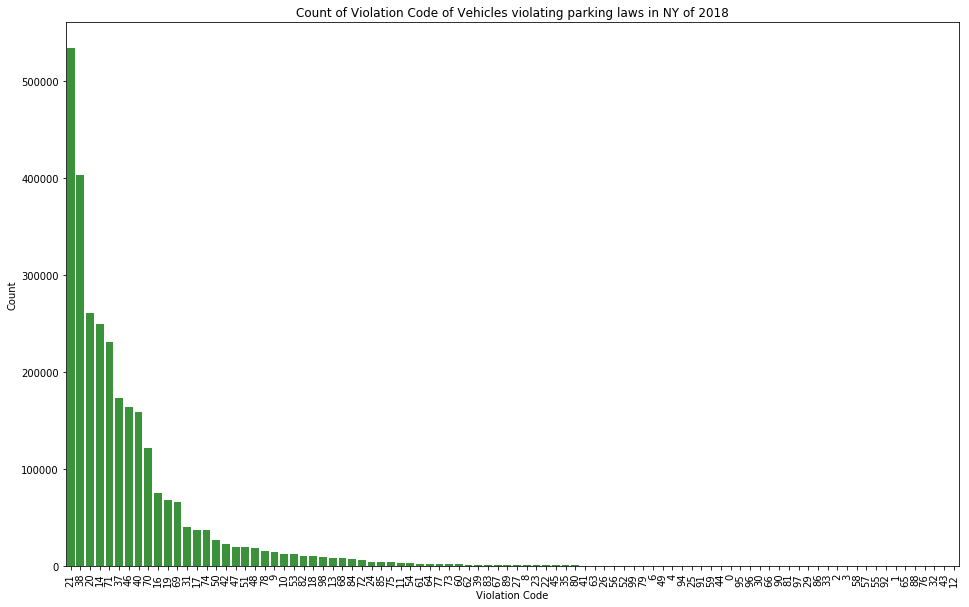

In [58]:
base_color = sb.color_palette()[2]
vio_order = df.violation_code.value_counts().index
fig, ax = plt.subplots(figsize=(16, 10))
sb.countplot(data = df, x = 'violation_code', color = base_color, order = vio_order)
plt.xlabel('Violation Code')
plt.ylabel('Count')
plt.title('Count of Violation Code of Vehicles violating parking laws in NY of 2018')
plt.xticks(rotation = 90);

**After removing non-parking violation in top 10, the top 10 parking violations in NY in 2018 are as follows (in ascending order):**

* 21: Street Cleaning: No parking where parking is not allowed by sign, street marking or traffic control device.
* 38: Failing to show a receipt or tag in the windshield.
* 20: General No Parking: No parking where parking is not allowed by sign, street marking or traffic control device.
* 14: General No Standing: Standing or parking where standing is not allowed by sign, street marking or; traffic control device.
* 71: Standing or parking a vehicle without showing a current New York inspection sticker.
* 37: Expired parking receipt
* 46: Standing or parking on the roadway side of a vehicle stopped, standing or parked at the curb (double parking)
* 40: Stopping, standing or parking closer than 15 feet of a fire hydrant.
* 70: Standing or parking a vehicle without showing a current New York registration sticker.
* 16: Truck Loading/Unloading: Standing or parking where standing is not allowed by sign, street marking or; traffic control device.

In [59]:
code_list = ['21', '38', '20', '14', '71', '37', '46', '40', '70', '16']
df.query('violation_code == @code_list').violation_code.value_counts().sum() / df.violation_code.count()

0.8216101583287231

**The top 10 parking violation can be further summarized as follows:**
1. Parking where you are not supposed to (21, 20, 14, 46, 40, 16)
2. No parking receipt displayed on windshield (38)
3. No current NY Vehicle Inspection sticker
4. Expired parking receipt
5. No current NY Vehicle Registration sticker

These 5 parking violations were responsible for 82.2% of all parking violations in NY in 2018

### Vehicle Body Types

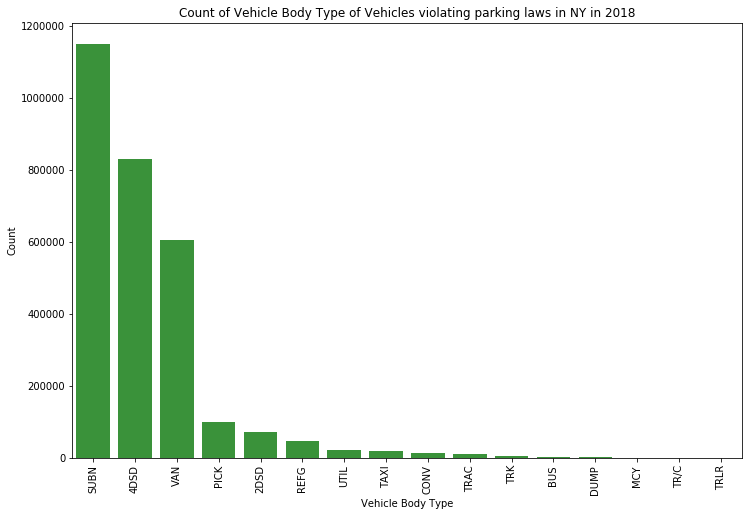

In [65]:
# order by value counts index / change color
body_order = df.vehicle_body_type.value_counts().index

fig, ax = plt.subplots(figsize=(12, 8))
sb.countplot(data = df, x = 'vehicle_body_type', order = body_order, color = base_color)
plt.title('Count of Vehicle Body Type of Vehicles violating parking laws in NY in 2018')
plt.xlabel('Vehicle Body Type')
plt.ylabel('Count')
plt.xticks(rotation = 90);

In [66]:
(df.query('vehicle_body_type == "SUBN"').vehicle_body_type.count() + df.query('vehicle_body_type == "4DSD"').vehicle_body_type.count() + df.query('vehicle_body_type == "VAN"').vehicle_body_type.count()) / df.vehicle_body_type.count()

0.8961136738946869

Almost 90% (~89.6%) of all cars that violated NY parking law in 2018 were all either an SUV, 4 Door Sedan, or a Van (Minivan included). Important to note that this may just be a representation of all vehicles in NY, not that the above vehicles are more likely to violate parking laws.

We can see that there are less Sports cars (2DSD) than traditional 4 Door sedans, less buses than taxis, which would be true in the whole vehicle population in NY. According to an article by USATODAY (https://www.usatoday.com/story/news/nation-now/2017/08/30/these-most-popular-cars-and-trucks-every-state/478537001/) Nissan Rogue, an SUV, was the most common vehicle in NY in 2016.

With this, we can safely expect that what is represented here is representative of the whole NY vehicle population.

### Vehicle Make

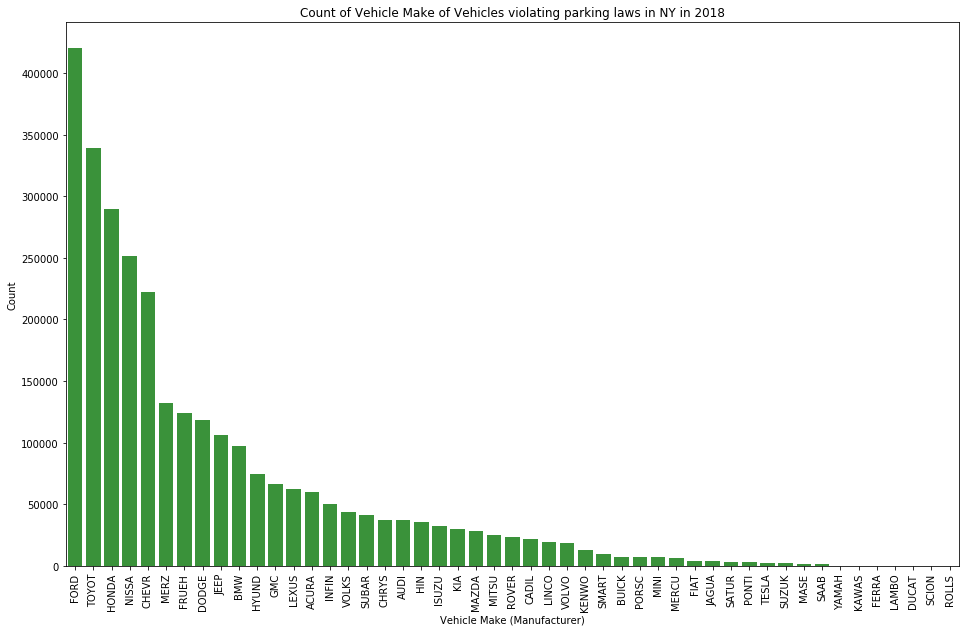

In [10]:
make_order = df.vehicle_make.value_counts().index

fig, ax = plt.subplots(figsize=(16, 10))
sb.countplot(data = df, x = 'vehicle_make', order = make_order, color = base_color)
plt.title('Count of Vehicle Make of Vehicles violating parking laws in NY in 2018')
plt.xlabel('Vehicle Make (Manufacturer)')
plt.ylabel('Count')
plt.xticks(rotation = 90);

In [11]:
(df.query('vehicle_make == "FORD"').vehicle_make.count() + df.query('vehicle_make == "TOYOT"').vehicle_make.count() + df.query('vehicle_make == "HONDA"').vehicle_make.count() + df.query('vehicle_make == "NISSA"').vehicle_make.count() + df.query('vehicle_make == "CHEVR"').vehicle_make.count()) / df.vehicle_make.count()

0.5280250436412695

The Top 5 most common vehicle manufacturers make up more than 50% (~53%) of all vehicles that violated parking laws in NY in 2018. Again, it's important to note that the Top 5 vehicles represented here does not predict which vehicles make is most likely to violate parking law, but is simply a representation of vehicles that violated parking law in NY in 2018, and is most likely a representative sample of the whole vehicle population in NY of 2018. 

From our everyday lives and our time on the road, this data does not seem too far from what one would expect on the roads of NY. We've got budget and economy-friendly cars in the Top 5. As we reach the lower end, we start seeing luxury cars like Ferrari, Lamborghini, Ducati, and Rolls Royce.

### Vehicle Color

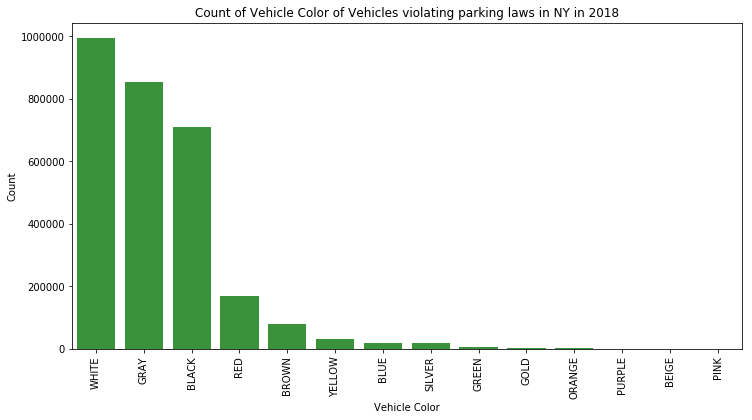

In [14]:
color_order = df.vehicle_color.value_counts().index

fig, ax = plt.subplots(figsize=(12, 6))
sb.countplot(data = df, x = 'vehicle_color', order = color_order, color = base_color)
plt.title('Count of Vehicle Color of Vehicles violating parking laws in NY in 2018')
plt.xlabel('Vehicle Color')
plt.ylabel('Count')
plt.xticks(rotation = 90);

In [15]:
(df.query('vehicle_color == "WHITE"').vehicle_color.count() + df.query('vehicle_color == "GRAY"').vehicle_color.count() + df.query('vehicle_color == "BLACK"').vehicle_color.count()) / df.vehicle_color.count()

0.8860938602730647

Top 3 most common color of vehicle to violate parking law in NY in 2018 are not surprisingly monochrome colors, White, Gray, and Black, as one would expect from their time on the road in virtually any city in North America. 

These 3 color vehicles make up 89% (~88.6%) of all vehicles found to be violating a parking law in NY in 2018.

There is a huge decline in vehicles in other colors starting with Red. This is likely due to colors outside of the Top 3 increasing automobile insurance cost rather than personal preference, manufacturers focusing their production on Top 3 colors to save cost, a combined effect of both or additional factors. 

### Vehicle Year

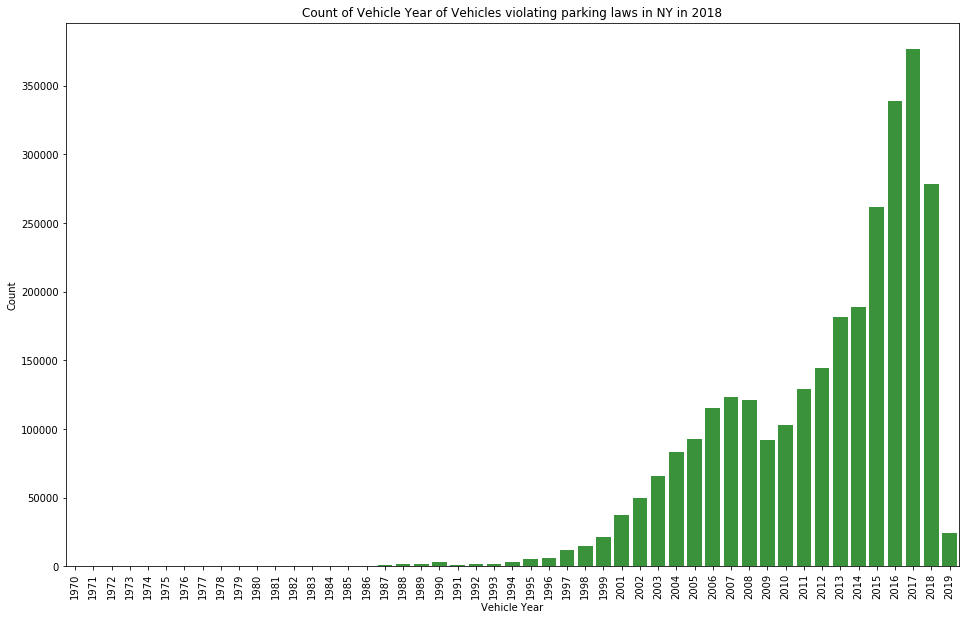

In [16]:
fig, ax = plt.subplots(figsize=(16, 10))
sb.countplot(data = df, x = 'vehicle_year', color = base_color)
plt.title('Count of Vehicle Year of Vehicles violating parking laws in NY in 2018')
plt.xlabel('Vehicle Year')
plt.ylabel('Count')
plt.xticks(rotation = 90);

There are a few things to be highlighted in this graph. First, 2019 vehicle models are released and sold throughout 2018. This is exactly why we are seeing 2019 vehicles in this dataset. Given that there was at most 12 months to sell 2019 model vehicles, this is clearly represented in the low number of 2019 year model vehicles. This effect is applied to 2018 model vehicles as well where the vehicles have had roughly 2 years in the market at most.

Secondly, we see that there is generally a diminishing trend in older vehicles. Assuming this dataset represents the whole population of vehicles in NY, this points to the fact that older cars are more susceptible to breaking down and no longer driven. The Top 3 vehicle years that violated parking laws in 2018 are 2017, 2016, and 2018 in descending order.

Lastly, I want to point out the small dip in vehicles going from 2008 to 2009, where both vehicle year models had plenty of time to be sold (~10 years since dataset is from 2018). Why would the vehicle count suddenly drop for 2009 models when there is a steady increasing trend in the past years? 

I would like to attribute this to the economic recession in US in 2008, which officially started in 2007, but really started affecting consumers in 2008, robbing their ability to purchase new vehicle models, which would be 2009. The automotive industry was hit very hard in the Great Recession, which should also be related with lower production of 2009 vehicle models.

### Season

In [27]:
# Let's create a new class and follow traditional order of seasons as written below:
season_classes = ['Spring', 'Summer', 'Fall', 'Winter']

pd_ver = pd.__version__.split(".")
if (int(pd_ver[0]) > 0) or (int(pd_ver[1]) >= 21): # v0.21 or later
    sclasses = pd.api.types.CategoricalDtype(ordered = True, categories = season_classes)
    df['season'] = df['season'].astype(sclasses)
else: # pre-v0.21
    df['season'] = df['season'].astype('category', ordered = True, categories = season_classes)

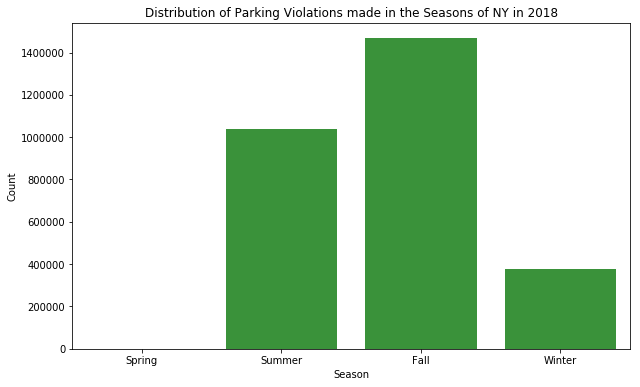

In [33]:
fig, ax = plt.subplots(figsize=(10, 6))
sb.countplot(data = df, x = 'season', color = base_color)
plt.title('Distribution of Parking Violations made in the Seasons of NY in 2018')
plt.xlabel('Season')
plt.ylabel('Count');

In [4]:
(df.query('season == "Summer"').season.count() + df.query('season == "Fall"').season.count()) / df.season.count()

0.869396700223123

In [36]:
df.query('season == "Spring"').season.count()

295

Before further discussion regarding the data, I would like to point out that I classified the following months into each seasons:
* Spring: March - May
* Summer: June - August
* Fall: September - November
* Winter: December - February

Parking violations filed between June and November make up roughly 87% (~86.9%) of all parking violations in NY in 2018.

What happened to parking violations in the Spring of 2018 in New York? It seems impossible that only 295 parking violations had been reported in the Spring of 2018. 

The rest of data seems to align with common assumptions of human activity. People are less likely to go out when the weather is not cooperative, especially in Winter (and Winter in NY can get quite cold!) and this applies for both drivers and parking enforcement. Hence, we see a huge drop in parking violations in the Winter months.

I will need spend additional time on the dataset to determine whether my wrangling process resulted in Spring month parking violations being removed from the dataset OR if the dataset is incomplete due to human error or by an unpreventable cause.

### Time of Day

In [37]:
tod_classes = ['Morning', 'Afternoon', 'Evening', 'Overnight']

pd_ver = pd.__version__.split(".")
if (int(pd_ver[0]) > 0) or (int(pd_ver[1]) >= 21): # v0.21 or later
    tclasses = pd.api.types.CategoricalDtype(ordered = True, categories = tod_classes)
    df['tod'] = df['tod'].astype(tclasses)
else: # pre-v0.21
    df['tod'] = df['tod'].astype('category', ordered = True, categories = tod_classes)

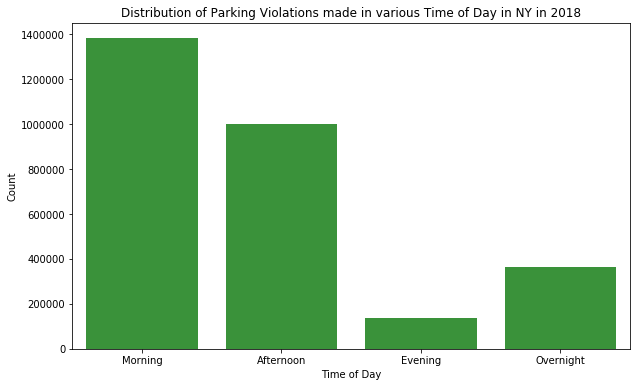

In [41]:
fig, ax = plt.subplots(figsize=(10, 6))
sb.countplot(data = df, x = 'tod', color = base_color)
plt.title('Distribution of Parking Violations made in various Time of Day in NY in 2018')
plt.xlabel('Time of Day')
plt.ylabel('Count');

In [5]:
(df.query('tod == "Morning"').tod.count() + df.query('tod == "Afternoon"').tod.count()) / df.tod.count()

0.8199674092587048

Before further discussion regarding the data, I would like to point out that I classified the following hours into each time of day:
* Overnight: 00:00 - 05:59
* Morning: 06:00 - 11:59
* Afternoon: 12:00 - 17:59
* Evening: 18:00 - 23-59

The above data seem to align with common assumptions of human activity. We take vehicles out the most during morning and afternoon, usually due to work or going outside in general.

Parking violations filed between 06:00 - 17:59 make up roughly 82% of all parking violations in NY in 2018.